# ML/NLP data scientist take-home exercise


The 2019 coronavirus disease (COVID-19, https://en.wikipedia.org/wiki/Coronavirus_disease_2019) is an infectious disease caused by severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2). The disease has spread globally, resulting in the 2019–20 coronavirus pandemic.
 
Research into a solution for this problem is at full steam and, so far, more than 2000 research papers related to this have been published. As this number grows, keeping track of what is happening, recent results, etc., is becoming harder and harder. This is where modern advances in AI, ML and NLP are called for coming into action.

## Your task
 
Your mission is to create a report or dashboard that can be used by decision-makers and researchers to know what science results are being produced.
 
## Data
 
Many institutions and organizations, like the World Health Organization (WHO, https://www.who.int), or the Center for Disease Control and Prevention (CDC, https://www.cdc.gov) are gathering data and information related to the pandemic.
 
One of these organizations is the MIDAS Coordination Center (https://midasnetwork.us/mcc/). They are actively compiling and sharing information through the GitHub repository https://github.com/midas-network/COVID-19. In particular, they are sharing an export their Mendeley paper collection as XML files in  
https://github.com/midas-network/COVID-19/tree/master/documents/mendeley_library_files/xml_files
 
**Note:** You are expected to use the latest XML as the source of documents but you are free to cross the information stored here with other freely available on the web.

## Tasks
 
Given a list of papers create a report with the results of:
 
1. Read the most recent MIDAS Mendeley paper library XML file.
2. Generate groups of similar papers and assign a meaningful label or group of tags to each group.
3. Outline what papers inside each group better represent that group.
4. For each paper, provide a brief "one-liner" description of what the paper's main idea is.
5. Identify papers that represent potential breakthroughs

In [8]:
import pandas as pd

dataset = pd.read_pickle('./dataset_covid_groups.pkl')

# Task 4

There have been several attempts to solve the problem of automatic summarization of text. Various models based on machine learning have been proposed for this task. Most of these approaches model this problem as a classification problem (supervised) which outputs whether to include a sentence in the summary or not. 

Other approaches (e.g. TextRank) have used topic information, Latent Semantic Analysis (LSA), Sequence to Sequence models to finds how similar each sentence is to all other sentences in the text. The most important sentence is the one that is most similar to all the others. 

In [27]:
from sumy.nlp.tokenizers import Tokenizer
from sumy.parsers.plaintext import PlaintextParser
from sumy.summarizers.lsa import LsaSummarizer
from sumy.summarizers.lex_rank import LexRankSummarizer
from sumy.nlp.stemmers import Stemmer
from sumy.utils import get_stop_words


LANGUAGE = "english"
SENTENCES_COUNT = 1

stemmer = Stemmer(LANGUAGE)
summarizer = LexRankSummarizer(stemmer)
summarizer.stop_words = get_stop_words(LANGUAGE)

def summarize_text(text):
    parser = PlaintextParser.from_string(text, Tokenizer(LANGUAGE))
    return [sentence.__str__() for sentence in summarizer(parser.document, SENTENCES_COUNT)][0]

In [28]:
%time dataset['summary_lex'] = dataset['text'].apply(summarize_text)

CPU times: user 5.73 s, sys: 17.9 ms, total: 5.74 s
Wall time: 5.82 s


With the advent of new research in the state of the art models, more powerful algorithms are being developed for representing documents and sentences that can be employed effectively for the task of summarization.

## Summarization using SciBERT

We utilize the Bert Extractive Summarizer from the huggingface library along with SciBERT tokenizer. 
SciBERT is a Pretrained Language Model for Scientific Text, which is a BERT model trained on scientific text. 
The training corpus was papers taken from Semantic Scholar. Corpus size is 1.14M papers, 3.1B tokens. 
This tool utilizes the HuggingFace Pytorch transformers library to run extractive summarizations by first embedding the sentences, then running a clustering algorithm, finding the sentences that are closest to the cluster's centroids.
More information [3]: 

    [3] Miller, Derek. "Leveraging BERT for extractive text summarization on lectures." arXiv preprint arXiv:1906.04165 (2019).

In [32]:
import warnings
warnings.filterwarnings('ignore')
from transformers import *

# Load model, model config and tokenizer via Transformers
custom_config = AutoConfig.from_pretrained('allenai/scibert_scivocab_uncased')
custom_config.output_hidden_states=True
custom_tokenizer = AutoTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')
custom_model = AutoModel.from_pretrained('allenai/scibert_scivocab_uncased', config=custom_config)

In [33]:
from summarizer import Summarizer

model = Summarizer(custom_model=custom_model, custom_tokenizer=custom_tokenizer)

In [34]:
from tqdm.notebook import tqdm

dataset['summary'] = ''

for ix, row in tqdm(dataset.iterrows(), total=dataset.shape[0]):
    dataset.loc[ix, 'summary'] = model(row['text'], num_sentences=1)

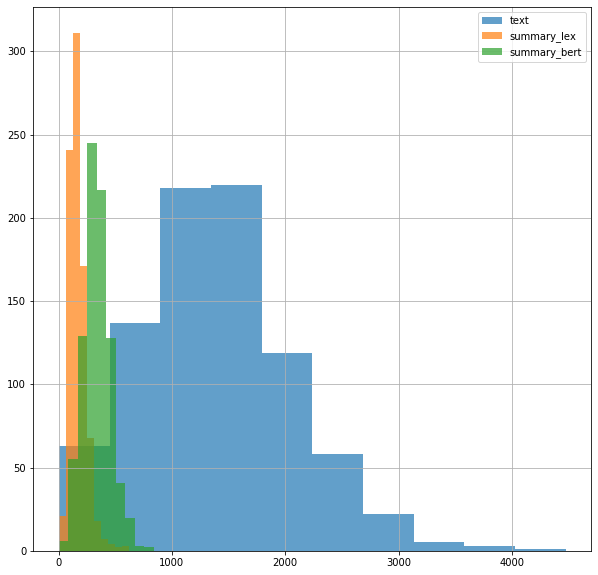

In [39]:
import pylab as plt

plt.figure(figsize=(10, 10))
dataset['text'].apply(lambda x: len(x)).hist(alpha=0.7)
dataset['summary_lex'].apply(lambda x: len(x)).hist(alpha=0.7)
dataset['summary'].apply(lambda x: len(x)).hist(alpha=0.7)
plt.legend(['text', 'summary_lex', 'summary_bert'])

Although we configured the length of bert summary to be one sentence, most of them are longer. 

In [40]:
# Longest Abstract 

dataset.loc[28, 'text']

'RAPID COMMUNICATION 22 March 2020 Estimating excess 1- year mortality from COVID-19 according to underlying conditions and age in England: a rapid analysis using NHS health records in 3.8 million adults Background: The medical, health service, societal and economic impact of the COVID-19 emergency has unknown effects on overall population mortality. Previous models of population mortality are based on death over days among infected people, nearly all of whom (to date at least) have underlying conditions. Models have not incorporated information on high risk conditions or their longer term background (pre-COVID-19) mortality. We estimated the excess number of deaths over 1 year under different COVID-19 incidence rates and differing mortality impacts. Methods: Using population based linked primary and secondary care electronic health records in England (HDR UK - CALIBER), we report the prevalence of underlying conditions defined by UK Public Health England COVID-19 guidelines (16 March 

In [42]:
dataset.loc[28, 'summary_lex']

'We estimated the 1-year mortality in each condition, and developed simple models of excess COVID-19-related deaths assuming relative risk (RR) of the impact of the emergency (compared to background mortality) of 1.2, 1.5 and 2.0.'

In [43]:
dataset.loc[28, 'summary']

'RAPID COMMUNICATION 22 March 2020 Estimating excess 1- year mortality from COVID-19 according to underlying conditions and age in England: a rapid analysis using NHS health records in 3.8 million adults Background: The medical, health service, societal and economic impact of the COVID-19 emergency has unknown effects on overall population mortality. We estimated the 1-year mortality in each condition, and developed simple models of excess COVID-19-related deaths assuming relative risk (RR) of the impact of the emergency (compared to background mortality) of 1.2, 1.5 and 2.0.'

In [44]:
dataset['summary_overlap'] = dataset.apply(lambda x: x['summary_lex'].strip() in x['summary'].strip()  , axis=1)
dataset.groupby('summary_overlap').size()

summary_overlap
False    400
True     446
dtype: int64

More than half of the summaries produced by lex_rank are overlapping the bert summaries. Let's investigate the non-overlapping summaries. 

In [46]:
# Longest non-overlapping summary

dataset.loc[304, 'text']

'Background: The COVID-19 outbreak containment strategies in China based on non-pharmaceutical interventions (NPIs) appear to be effective. Quantitative research is still needed however to assess the efficacy of different candidate NPIs and their timings to guide ongoing and future responses to epidemics of this emerging disease across the World. Methods: We built a travel network-based susceptible-exposed-infectious-removed (SEIR) model to simulate the outbreak across cities in mainland China. We used epidemiological parameters estimated for the early stage of outbreak in Wuhan to parameterise the transmission before NPIs were implemented. To quantify the relative effect of various NPIs, daily changes of delay from illness onset to the first reported case in each county were used as a proxy for the improvement of case identification and isolation across the outbreak. Historical and near-real time human movement data, obtained from Baidu location-based service, were used to derive the 

In [47]:
dataset.loc[304, 'summary_lex']

'Without NPIs, the number of COVID-19 cases would likely have shown a 67-fold increase (IQR: 44 - 94), with the effectiveness of different interventions varying.'

In [48]:
dataset.loc[304, 'summary']

'Background: The COVID-19 outbreak containment strategies in China based on non-pharmaceutical interventions (NPIs) appear to be effective. Conclusion: The NPIs deployed in China appear to be effectively containing the COVID-19 outbreak, but the efficacy of the different interventions varied, with the early case detection and contact reduction being the most effective.'

While the summary produced by lex looks like a "one-liner" description of what the paper's main idea, the second summary elaborates the details of the abstract in more depth.

In [51]:
# shortest non-overlapping abstract

dataset.loc[440, 'text']

'On 5 February 2020, in Yokohama, Japan, a cruise ship hosting 3,711 people underwent a 2-week quarantine after a former passenger was found with COVID-19 post-disembarking. As at 20 February, 634 persons on board tested positive for the causative virus. We conducted statistical modelling to derive the delay-adjusted asymptomatic proportion of infections, along with the infections’ timeline. The estimated asymptomatic proportion was 17.9% (95% credible interval (CrI): 15.5–20.2%). Most infections occurred before the quarantine start.'

In [52]:
dataset.loc[440, 'summary_lex']

'We conducted statistical modelling to derive the delay-adjusted asymptomatic proportion of infections, along with the infections’ timeline.'

In [53]:
dataset.loc[440, 'summary']

'On 5 February 2020, in Yokohama, Japan, a cruise ship hosting 3,711 people underwent a 2-week quarantine after a former passenger was found with COVID-19 post-disembarking.'

The summary produced by bert seems to be more suitable for larger texts.

# Task 5

The conception of *breakthrough* research is typically linked to discovery and often characterized as creative, transformative and ground breaking research. To precisely define what could constitute a breakthrough paper or breakthrough research is very difficult and eventually turns out to be rather vague and a matter to be decided by
peers. Hence, identifying potential breakthrough in scientific papers is arguably related to citation analysis. 

In an ideal scholarly document repository system, one can monitor the number of citations along with other bibliometric information to identify signals for potential breakthrough. However, this path is out of scope for this particular assignment and we have to limit our solution to the content of the abstracts. 

Our method for identifying breakthrough within our limited corpus we use the following mechanism:
    - sorting the corpus based on publication week.
    - aggregating the topic coefficients across the papers.
    - identifying top topics with increasing coefficients compare to the rate of increase in the number of papers.
    - identifying top papers that are published with the highest basis vector values in that week.

In [55]:
dataset.groupby('week').size()

week
2.0       2
3.0       1
4.0      24
5.0      44
6.0      55
7.0      81
8.0      85
9.0     131
10.0    134
11.0    112
12.0     68
13.0     17
16.0      3
dtype: int64

In [169]:
weekly = pd.concat([dataset[['title', 'topic', 'topic_coef', 'published', 'week']], pd.json_normalize(dataset['topics'].apply(lambda x: {topic_id:coef for topic_id, coef in x})).fillna(0)], axis=1)

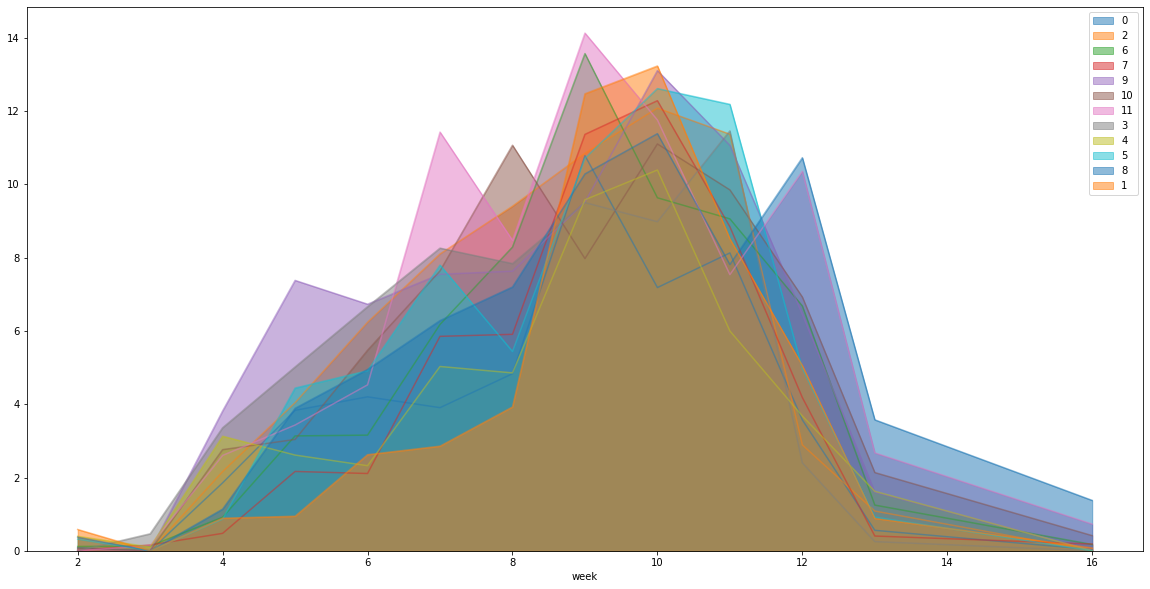

In [171]:
weekly[weekly.columns[4:]].groupby('week').sum().plot.area(stacked=False, figsize=(20, 10))

In [172]:
data_columns = ['week'] + [i for i in range(12)]

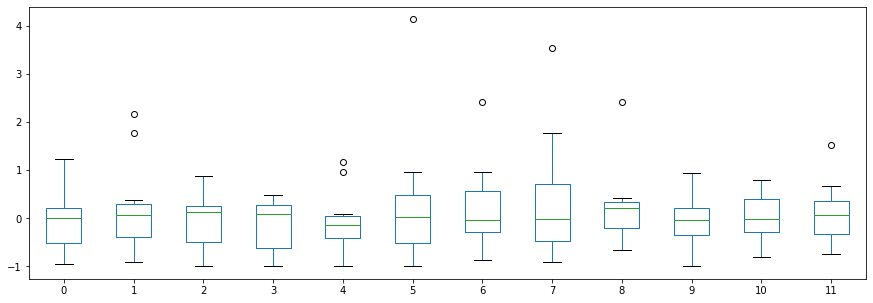

In [270]:
# Box-plot percent change topic coefficient over week.

weekly[weekly['week'] > 3][data_columns].groupby('week').sum().pct_change().plot(kind='box', figsize=(15, 5))

The outliers can potentially be an indicator of a breakthrough.

In [271]:
topic_dist = weekly[weekly['week'] > 3][data_columns].groupby('week').sum().pct_change().values

In [299]:
import numpy as np

def detect_outliers(data):
    m = 1.75
    u = np.nanmean(data)
    s = np.nanstd(data)

    filtered = [i for i, e in enumerate(data) if np.isfinite(e) and not (u - m * s < e < u + m * s)]
    return filtered

outliers = []
for topic_id in range(12):
    for week in detect_outliers(topic_dist[:, topic_id]):
        outliers.append((week+3, topic_id))

In [301]:
for week, topic in outliers:
    for ix, row in dataset[(dataset['week'] == week) & (dataset['topic'] == topic)].iterrows():
        print('Title:', row['title'])
        print('Summary:', row['summary_lex'])
        print('Date:', row['published'])
        print()

Title: Chest CT Findings in Coronavirus Disease-19 (COVID-19): Relationship to Duration of Infection
Summary: Abstract In this retrospective study, chest CTs of 121 symptomatic patients infected with coronavirus disease-19 (COVID-19) from four centers in China from January 18, 2020 to February 2, 2020 were...
Date: 2020-02-20T16:28:36Z

Title: Single-cell Analysis of ACE2 Expression in Human Kidneys and Bladders Reveals a Potential Route of 2019-nCoV Infection
Summary: Our findings suggested the kidney abnormalities of SARS and 2019-nCoV patients may be due to proximal tubule cells damage and subsequent systematic inflammatory response induced kidney injury.
Date: 2020-02-19T06:18:23Z

Title: Clinical Characteristics and Progression of 2019 Novel Coronavirus-Infected Patients Concurrent Acute Respiratory Distress Syndrome
Summary: The difference in treatment and progression between patients with ARDS and without ARDS was compared.
Date: 2020-02-20T22:15:42Z

Title: Clinical Characteris